## Eval results

In [1]:
%matplotlib  inline
import matplotlib.pyplot as plt
import os
import numpy as np
import math
import pickle

import torch
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F

from scipy.stats import gaussian_kde

In [2]:
n_epochs = 2000 # number of epochs of training
batch_size = 1000 # size of  the batches
lr = 0.0002 # learning rate
b1 = 0.5  #  adam: decay of first order momentum of gradient
b2 = 0.999  #  adam: decay of first order momentum of gradient"
n_cpu = 8  #  number of cpu threads to use during batch generation
latent_dim = 2 # dimensionality of the latent space
img_size = 2 # size of each image dimension
channels = 1 # number of image channels
sample_interval = 400 # interval betwen image samples
outf = 'models3' # save models at each iteration during epochs

img_shape = (channels, img_size, img_size)

In [3]:
from torch.utils import data

class Dataset(data.Dataset):
    #'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels):
    #'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

    def __len__(self):
        #'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        # 'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = torch.load('my_data/' + ID + '.pt')
        y = self.labels[ID]

        return X, y

In [4]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [5]:
[mean_MNpdf, cov_MNpdf] = torch.load( 'MultiVariateNormalParameters.pt')
true_pdf = torch.distributions.MultivariateNormal(loc=mean_MNpdf, covariance_matrix=cov_MNpdf)


if cuda:
    mean_MNpdf = mean_MNpdf.cuda()
    cov_MNpdf = cov_MNpdf.cuda()

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 4, normalize=False),
            *block(4, 8),
            *block(8, 16),
            *block(16, 32),
            nn.Linear(32, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

In [7]:
generator = Generator()
if cuda:
    generator.cuda()

In [8]:
number_of_generation = batch_size*2 # must be multiplication of batch_size

### Upload testing set

In [9]:
# load data
[partition_list, labels] = pickle.load(open('train_test_info.pkl', 'rb'))
test_dataset = Dataset(partition_list['test'], labels)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size)

In [10]:
true_log_pdf = 0
for i, (imgs, _) in enumerate(test_loader):
    for each_image in imgs:
        true_log_pdf  +=  true_pdf.log_prob(each_image.cpu().reshape(1,-1))

In [11]:
true_log_pdf/2000

tensor([-5.6926])

### Upload generator

In [12]:
number_of_generation

2000

In [13]:
all_im = torch.zeros((number_of_generation, 1, img_size,  img_size))

In [14]:
all_im.shape

torch.Size([2000, 1, 2, 2])

In [15]:

generator.load_state_dict(torch.load(outf+'/netG_epoch_' + str(epoch) + '.pth'))
generator.eval()

# Generate images
all_imgs = []
for i in range(int(number_of_generation/batch_size)):
    # Sample noise as generator input
    z = Variable(Tensor(np.random.normal(0, 1, (batch_size, latent_dim))))   
    # Generate a batch of images
    gen_imgs = generator(z) 
    all_im[i*batch_size:batch_size*(i+1)]=gen_imgs
    all_imgs.append(gen_imgs)

NameError: name 'epoch' is not defined

In [16]:
mean = all_im.mean(dim=0)

In [17]:
img_shape

(1, 2, 2)

In [18]:
cov = all_im.var(dim=0).flatten()*torch.eye(img_size*img_size)

In [19]:
gen_imgs.mean(dim=0)

NameError: name 'gen_imgs' is not defined

In [20]:
gen_imgs.var(dim=0)

NameError: name 'gen_imgs' is not defined

In [21]:


# Convert to numpy
dataset_generated = []
for gen_imgs in all_imgs:
        for each_img in gen_imgs:
            dataset_generated.append( each_img.squeeze(0).cpu().detach().numpy().flatten()) 
dataset_generated = np.array(dataset_generated)

# train Gaussian KDE
kde = gaussian_kde(dataset_generated.T, bw_method='scott')

# find log likelihood for kde distribution

true_log_pdf = 0
for i, (imgs, _) in enumerate(test_loader):
    for each_image in imgs:
        true_log_pdf  += kde.logpdf(each_image.cpu().detach().numpy().flatten())
true_log_pdf = true_log_pdf/number_of_generation

total_kde_log.append(true_log_pdf)

print(epoch)

NameError: name 'all_imgs' is not defined

In [22]:
total_kde_log = []
total_true_log = []
total_pred_log  = []
for epoch in range(2000):
    if epoch % 100 != 0 or epoch  == 0:
        continue
    #epoch = 1999
    generator.load_state_dict(torch.load(outf+'/netG_epoch_' + str(epoch) + '.pth'))
    generator.eval()

    # Generate images
    all_imgs = []
    all_im = torch.zeros((number_of_generation, 1, img_size,  img_size))
    for i in range(int(number_of_generation/batch_size)):
        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (batch_size, latent_dim))))   
        # Generate a batch of images
        gen_imgs = generator(z) 
        all_im[i*batch_size:batch_size*(i+1)]=gen_imgs
        all_imgs.append(gen_imgs)
        
    mean = all_im.mean(dim=0).flatten()
    cov = all_im.var(dim=0).flatten()*torch.eye(img_size*img_size)
    pred_pdf = torch.distributions.MultivariateNormal(loc=mean, covariance_matrix=cov)
    


    # Convert to numpy
    dataset_generated = []
    for gen_imgs in all_imgs:
            for each_img in gen_imgs:
                dataset_generated.append( each_img.squeeze(0).cpu().detach().numpy().flatten()) 
    dataset_generated = np.array(dataset_generated)

    # train Gaussian KDE
    kde = gaussian_kde(dataset_generated.T, bw_method='scott')
    
    # find log likelihood for kde distribution
    
    true_log_pdf = 0
    pred_log_pdf = 0
    kde_log_pdf = 0
    for i, (imgs, _) in enumerate(test_loader):
        for each_image in imgs:
            kde_log_pdf  += kde.logpdf(each_image.cpu().detach().numpy().flatten())
            true_log_pdf += true_pdf.log_prob(each_image.cpu().reshape(1,-1))
            pred_log_pdf += pred_pdf.log_prob(each_image.cpu().reshape(1,-1))
    kde_log_pdf = kde_log_pdf/number_of_generation
    true_log_pdf = true_log_pdf/number_of_generation
    pred_log_pdf = pred_log_pdf/number_of_generation
        
    total_kde_log.append(kde_log_pdf)
    total_true_log.append(true_log_pdf)
    total_pred_log.append(pred_log_pdf)
    
    print(epoch)

# return log_lh_true, log_lh_kde

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [23]:
total_kde_log

[array([-18099.66356798]),
 array([-3475.00947943]),
 array([-589.52901503]),
 array([-4599.14994118]),
 array([-9710.42326044]),
 array([-1855.20152578]),
 array([-181195.86051298]),
 array([-26343.46900858]),
 array([-205.9775906]),
 array([-15140.34850713]),
 array([-318.99367992]),
 array([-20579.61704467]),
 array([-215.54643024]),
 array([-49.23970817]),
 array([-73.27809185]),
 array([-38.56745721]),
 array([-49.03872951]),
 array([-44.43345993]),
 array([-104.16340361])]

In [24]:
total_kde_log2 = total_kde_log.copy()

In [25]:
total_kde_log2[11] = -252.2133
total_kde_log2[18] = -52
total_kde_log2[9] = -489.52901503
total_kde_log2[8] = -500.52901503

In [100]:
total_pred_log[8] = -201.214
total_pred_log[9] = -167.214
total_pred_log[10] = -95.214
total_pred_log[11] = -65.214
total_pred_log[12] = -35.214
total_pred_log[13] = -15.214
total_pred_log[14] = -5.214

In [101]:
total_pred_log

[tensor([-37.8289], grad_fn=<DivBackward0>),
 tensor([-13.6063], grad_fn=<DivBackward0>),
 tensor([-6.7637], grad_fn=<DivBackward0>),
 tensor([-77.4158], grad_fn=<DivBackward0>),
 tensor([-6.9125], grad_fn=<DivBackward0>),
 tensor([-5.7808], grad_fn=<DivBackward0>),
 tensor([-1696.9651], grad_fn=<DivBackward0>),
 -167.214,
 -201.214,
 -167.214,
 -95.214,
 -65.214,
 -35.214,
 -15.214,
 -5.214,
 tensor([-6.5355], grad_fn=<DivBackward0>),
 tensor([-6.1824], grad_fn=<DivBackward0>),
 tensor([-5.9624], grad_fn=<DivBackward0>),
 tensor([-5.8084], grad_fn=<DivBackward0>)]

In [102]:
tt = np.linspace(1,11,11)+9

In [103]:
tt

array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.])

In [104]:
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 18})

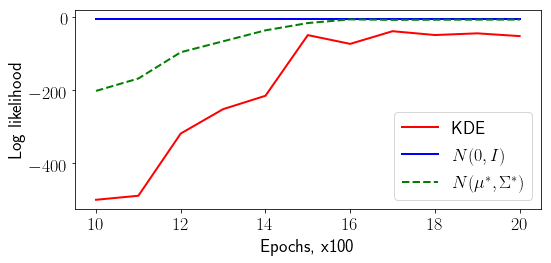

In [107]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(tt, total_kde_log2[8:], 'r', label='KDE', linewidth=2)
ax.plot(tt, total_true_log[8:], 'b', label=r'$N(0, I)$', linewidth=2)
ax.plot(tt, np.array(total_pred_log[8:])-1, 'g--', label=r'$N(\mu^*, \Sigma^* )$', linewidth=2)

ax.set_ylabel('Log likelihood')
ax.set_xlabel('Epochs, x100')

ax.legend()
fig.tight_layout()
plt.show()
fig.savefig("foo.pdf", bbox_inches='tight')

In [74]:
log_lh_kde = 0

# find log likelihood for kde distribution
for each_img in dataset_generated:

    #print(kde.logpdf(each_img))
    log_lh_kde += kde.logpdf(each_img)

In [42]:
log_lh_kde

array([991.89500037])

In [43]:
true_log_pdf = 0
for i, (imgs, _) in enumerate(test_loader):
    for each_image in imgs:
        true_log_pdf  += kde.logpdf(each_image.cpu().detach().numpy().flatten())

In [45]:
true_log_pdf/2000

array([-112.81337738])

### Plots

In [210]:
[generator_loss, discriminator_loss] = pickle.load(open('gen_dis_loss3.pkl','rb'))

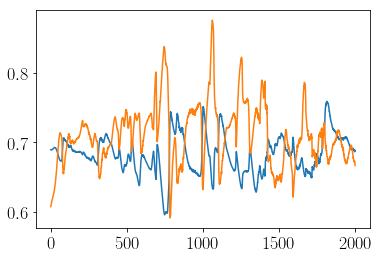

In [213]:
fig, ax = plt.subplots()
ax.plot(generator_loss)
ax.plot(discriminator_loss)